In [1]:
import numpy as np
import pandas as pd
import sklearn
from sklearn import neighbors
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error

%matplotlib inline
import matplotlib.pyplot as plt

Let's start by importing our data and performing additional processing. We are going to do two forms of additional processing. First we are going to drop all data before March 16, 2020 because hospitalizations at this point are zero. Second, we are going to drop regions that have zero (or almost zero in the case of VT) hospitalizations.

In [2]:
hospPredictions = np.genfromtxt('combined2.csv', delimiter=',', skip_header=True, usecols = (125))
features = np.genfromtxt('combined2.csv', delimiter=',', skip_header=True, usecols = (range(123)))[:, 2:]
regions = np.genfromtxt('combined2.csv', delimiter=',', skip_header=True, usecols = (0), dtype = 'str')
dates = np.genfromtxt('combined2.csv', delimiter=',', skip_header=True, usecols = (1), dtype = 'datetime64')

droppedRegions = np.array((regions == "US-AK", regions == "US-DC", regions == "US-DE", regions == "US-VT"))
droppedRegionsIndices = np.argwhere(np.logical_or.reduce(droppedRegions))[:,0]
droppedDatesIndices = np.argwhere(dates <= np.datetime64('2020-03-16'))[:,0]
droppedDataIndices = np.unique(np.concatenate((droppedDatesIndices, droppedRegionsIndices)))

dates = np.delete(dates, droppedDataIndices, axis = 0)
features = np.delete(features, droppedDataIndices, axis = 0)
regions = np.delete(regions, droppedDataIndices, axis = 0)
hospPredictions = np.delete(hospPredictions, droppedDataIndices, axis = 0)

We'll also get some commonly used helpers out of the way.

This includes a method to perform KNN regression and return the mean squared error. The same is done for decision trees.

In [3]:
def knn(xTrain, yTrain, xValidation, yValidation, k = 5):
    """Performns a train-validation run of KNN and returns the mean squared error

    Keyword arguments:
    xTrain -- the features to train on
    yTrain -- the result to train on
    xValidation -- the features to validate with
    yValidation -- the expected validation results
    k -- the number of neighbors
    """
    knn = neighbors.KNeighborsRegressor(n_neighbors = k)
    knn.fit(xTrain, yTrain)
    prediction = knn.predict(xValidation)
    return mean_squared_error(yValidation, prediction)

def decisionTree(xTrain, yTrain, xValidation, yValidation, depth):
    """Performns decision tree regression and returns the mean squared error

    Keyword arguments:
    xTrain -- the features to train on
    yTrain -- the result to train on
    xValidation -- the features to validate with
    yValidation -- the expected validation results
    depth -- the max-depth of the decision tree
    """
    clf = tree.DecisionTreeRegressor(max_depth = depth, random_state=0)
    clf = clf.fit(xTrain, yTrain)
    prediction = clf.predict(xValidation)
    return mean_squared_error(yValidation, prediction)

With that out of the way, we can begin by splitting data based on the time. The selected time for the split is '2020-08-10'. Any dates after this will be in the validation set and the rest of the data will be used for training. We will then test it with KNN/Decision trees.

In all experiments below, are metric of choice is the mean squared error. We also display the root mean squared error in order to make things more human-interpetable.

KNN with K =  3
MSE  (KNN):    28.6
RMSE (KNN):     5.3



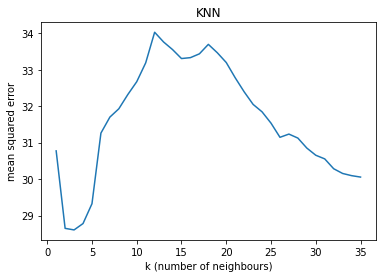

 
Decision tree with depth =  1
MSE  (DecisionTree):    28.7
RMSE (DecisionTree):     5.4



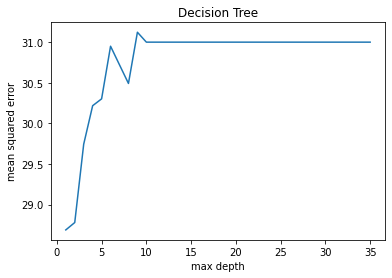

In [4]:
# neighbors to consider for KNN (as well as depths for the decision tree)
K_list = range(1,36)

# get the indices for train/test data
train_indices = np.argwhere(dates > np.datetime64("2020-08-10"))[:,0]
test_indices = np.argwhere(dates <= np.datetime64("2020-08-10"))[:,0]

# prep the dataset
xTrain = np.take(features, train_indices, axis = 0)
xValidation = np.take(features, test_indices, axis = 0)
yTrain = np.take(hospPredictions, train_indices, axis = 0)
yValidation = np.take(hospPredictions, test_indices, axis = 0)

error_list_knn = np.zeros(len(K_list))
error_list_tree = np.zeros(len(K_list))

for i, k in enumerate(K_list):
    error_list_knn[i] = knn(xTrain, yTrain, xValidation, yValidation, k)
    # checking all values in the k_list for the decision tree is redundant but it may as well be done in the same loop
    error_list_tree[i] = decisionTree(xTrain, yTrain, xValidation, yValidation, k)

min_error_knn_index = np.where(error_list_knn == error_list_knn.min())[0]
optimal_k = min_error_knn_index + 1
min_error_knn = error_list_knn[min_error_knn_index]

print("KNN with K = %2d" % (optimal_k))
print("MSE  (KNN): %7.1f" % (min_error_knn))
print("RMSE (KNN): %7.1f\n" % (np.sqrt(min_error_knn)))

plt.plot(K_list, error_list_knn)
plt.title('KNN')
plt.xlabel('k (number of neighbours)')
plt.ylabel('mean squared error')
plt.show()
print(" ")

min_error_tree_index = np.where(error_list_tree == error_list_tree.min())[0]
optimal_depth = min_error_tree_index + 1
min_error_tree = error_list_tree[min_error_tree_index]

print("Decision tree with depth = %2d" % (optimal_depth))
print("MSE  (DecisionTree): %7.1f" % (min_error_tree))
print("RMSE (DecisionTree): %7.1f\n" % (np.sqrt(min_error_tree)))

plt.plot(K_list, error_list_tree)
plt.title('Decision Tree')
plt.xlabel('max depth')
plt.ylabel('mean squared error')
plt.show()

We can now move onto a split by region. We will put 80% of regions in the training set and 20% in the validaiton set and perform 5-fold cross validation. Note that this separation is by regions and not total sample size. This is because simply splitting by the total number of instances may result in the same regions in both the validation and test set. For example, 336 datapoints are explored, which consists of 13 regions with 28 datapoints each. An 80-20 split of this would result in 67 instances in the validation set meaning that data from a region will be in both train and validation sets.

As we did previously, we want to select an optimal number of neighbours for KNN. We will do this by estimating all values of k for each fold, and then select the optimal on average.  We'll do the same for the max depth of the tree although this will be mostly redundant with our range for our dataset.

Note that whilst this experiment prints the optimal k as the minimum, this is not necessarily the case and the optimal k should be extrapolated by looking at the graph itself. This is further clarified in the report.

Optimal number of neighbors at K = 35
Mean MSE  (KNN):             32.5
Mean RMSE (KNN):              5.3



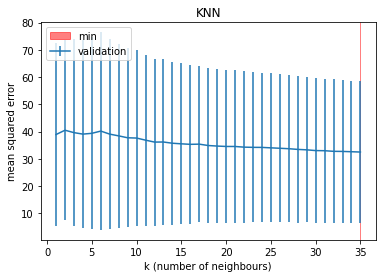

 
Optimal max depth 1
Mean MSE  (Decision Tree):    37.4
Mean RMSE (Decision Tree):     5.5



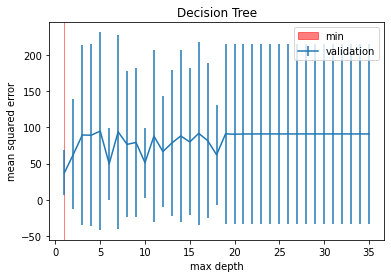

In [8]:
validation_mse_knn = np.zeros((len(K_list), 5))
validation_mse_tree = np.zeros((len(K_list), 5))

for (i, K) in enumerate(K_list):
    gkf = GroupKFold(n_splits=5)
    for (foldNumber, (train_idx, test_idx)) in enumerate(gkf.split(features, hospPredictions, regions)):
        # split to train validation
        xTrain = np.take(features, train_idx, axis=0)
        xValidation = np.take(features, test_idx, axis=0)
        yTrain = np.take(hospPredictions, train_idx, axis=0)
        yValidation = np.take(hospPredictions, test_idx, axis=0)

        # perform knn/decision tree regression
        validation_mse_knn[i, foldNumber] = knn(xTrain, yTrain, xValidation, yValidation, K)
        validation_mse_tree[i, foldNumber] = decisionTree(xTrain, yTrain, xValidation, yValidation, K)

# get the mean error for each fold for every value of k
mse_means = np.mean(validation_mse_knn, axis=1)
rmse_means = np.mean(np.sqrt(validation_mse_knn), axis = 1)
min_error_index = np.where(mse_means == np.min(mse_means))[0]
optimal_k = min_error_index + 1

print("Optimal number of neighbors at K = %d" % (optimal_k))
print("Mean MSE  (KNN):          %7.1f" % ((mse_means[min_error_index])))
print("Mean RMSE (KNN):          %7.1f\n" % ((rmse_means[min_error_index])))

plt.errorbar(K_list, mse_means, np.std(validation_mse_knn, axis=1), label='validation')
plt.axvspan(optimal_k, optimal_k, color='red', alpha=0.5, label = 'min')
plt.legend()
plt.title('KNN')
plt.xlabel('k (number of neighbours)')
plt.ylabel('mean squared error')
plt.show()

mse_means = np.mean(validation_mse_tree, axis=1)
rmse_means = np.mean(np.sqrt(validation_mse_tree), axis = 1)
min_error_index = np.where(mse_means == np.min(mse_means))[0]
optimal_depth = min_error_index + 1

print(" ")
print("Optimal max depth %d" % (optimal_depth))
print("Mean MSE  (Decision Tree): %7.1f" % ((mse_means[min_error_index])))
print("Mean RMSE (Decision Tree): %7.1f\n" % ((rmse_means[min_error_index])))

plt.errorbar(K_list, mse_means, np.std(validation_mse_tree, axis=1), label='validation')
plt.axvspan(optimal_depth, optimal_depth, color='red', alpha=0.5, label = 'min')
plt.legend()
plt.title('Decision Tree')
plt.xlabel('max depth')
plt.ylabel('mean squared error')
plt.show()

For additional testing, we will first model each region separately.

Once again, we will use both KNNs and decision trees.

This section was the first that indicated that our dataset was problematic and is what pushed us to further normalize hospitalizations as well as drop regions with no hospitalization data. Moreover, post normalization, it also pointed to how data between regions aren't necessarily easy to comparable.

Similar to previously, we tested for all values of neighbours, as well as max depth in order to select something that provided minimal error. Once again however, this would not necessarily be the optimal value for testing. No plotting was done here, as it would get a bit too crowded (24x plots, 2 for each region), although this is left commented for KNN if desired.

In [5]:
K_list = range(1,23)
combined = np.vstack((regions, features.T, hospPredictions)).T
# create a list of arrays that contains the features/predictions for a specific region
regionSplit = np.split(combined[:, :], np.cumsum(np.unique(combined[:, 0], return_counts=True)[1])[:-1]) 

for regionalData in regionSplit:
    currentRegion = regionalData[0,0] # extract the current region we're predicting
    x = regionalData[:, 1:-1].astype(np.float) # features for the specific region
    y = regionalData[:,-1].astype(np.float) # predictions for each instance of that region

    # here, we will perform knn/decision tree regression with a simple 80-20 split
    xTrain, xValidation, yTrain, yValidation = train_test_split(x, y, train_size = 0.8, random_state = 0)
    optimal_k, optimal_depth = -1, -1
    min_error_knn, min_error_tree = sys.maxsize, sys.maxsize

    for i in K_list:
        current_error_knn = knn(xTrain, yTrain, xValidation, yValidation, i)
        current_error_tree = decisionTree(xTrain, yTrain, xValidation, yValidation, i)

        if (current_error_knn < min_error_knn):
            min_error_knn = current_error_knn
            optimal_k = i
        if (current_error_tree < min_error_tree):
            min_error_tree = current_error_knn
            optimal_depth = i

    print("Region: %s | MSE (KNN, K = %2d): %7.1f | MSE (DecisionTree, depth = %2d): %7.1f" % (currentRegion, optimal_k, min_error_knn, optimal_depth, min_error_tree))

Region: US-HI | MSE (KNN, K =  1):     4.9 | MSE (DecisionTree, depth =  1):     4.9
Region: US-ID | MSE (KNN, K =  8):     4.5 | MSE (DecisionTree, depth =  2):     8.2
Region: US-ME | MSE (KNN, K =  2):     0.2 | MSE (DecisionTree, depth =  1):     0.2
Region: US-MT | MSE (KNN, K =  1):     1.2 | MSE (DecisionTree, depth =  1):     1.2
Region: US-ND | MSE (KNN, K =  2):     0.7 | MSE (DecisionTree, depth =  4):     1.1
Region: US-NE | MSE (KNN, K =  2):     3.9 | MSE (DecisionTree, depth =  2):     3.9
Region: US-NH | MSE (KNN, K =  5):     0.6 | MSE (DecisionTree, depth =  2):     1.2
Region: US-NM | MSE (KNN, K = 22):     8.8 | MSE (DecisionTree, depth =  2):    28.8
Region: US-RI | MSE (KNN, K =  8):   193.5 | MSE (DecisionTree, depth =  4):   221.6
Region: US-SD | MSE (KNN, K =  1):     0.9 | MSE (DecisionTree, depth =  1):     0.9
Region: US-WV | MSE (KNN, K = 22):    15.7 | MSE (DecisionTree, depth = 22):    15.7
Region: US-WY | MSE (KNN, K = 20):     1.0 | MSE (DecisionTree, d

As a final test, we will split test and train data by season. 

We will classify dates into:
- Fall
- Spring
- Summer

Note that winter is excluded because we filtered out winter dates when we processed the data.

We will then test on each season separately. The primary reasoning here is that COVID cases dropped during the summer and began increasing again towards the end of the summer. Therefore, it could be possible to at least account for an overall trend in cases even if regions vary drastically. 

Within each seasonal grouping, we will do a simple 80-20 validation train split.

In [9]:
# get the indices for datapoints within each season
summerIndices = np.argwhere(np.logical_and(dates >= np.datetime64('2020-06-01'), dates <= np.datetime64('2020-08-31')))[:,0]
fallIndices = np.argwhere(np.logical_and(dates >= np.datetime64('2020-08-01'), dates <= np.datetime64('2020-11-30')))[:,0]
springIndices = np.argwhere(np.logical_and(dates >= np.datetime64('2020-03-01'), dates <= np.datetime64('2020-05-31')))[:,0]

seasonLabels = ["Spring", "Summer", "Fall"]
# create an array of arrays s.t each array is the indices for a season
seasonIndexArray = np.array((springIndices, summerIndices, fallIndices))

for season, seasonIndices in enumerate(seasonIndexArray): 
    x = np.take(features, seasonIndices, axis = 0)
    y = np.take(hospPredictions, seasonIndices, axis = 0)
    
    xTrain, xValidation, yTrain, yValidation = train_test_split(x, y, train_size = 0.8, random_state = 0)
    optimal_k, optimal_depth = -1, -1
    min_error_knn, min_error_tree = sys.maxsize, sys.maxsize

    for i in K_list:
        current_error_knn = knn(xTrain, yTrain, xValidation, yValidation, i)
        current_error_tree = decisionTree(xTrain, yTrain, xValidation, yValidation, i)

        if (current_error_knn < min_error_knn):
            min_error_knn = current_error_knn
            optimal_k = i
        if (current_error_tree < min_error_tree):
            min_error_tree = current_error_tree
            optimal_depth = i

    print("Season: %6s | MSE (KNN, K = %2d): %7.1f | MSE (DecisionTree, depth = %2d): %7.1f" % (seasonLabels[season], optimal_k, min_error_knn, optimal_depth, min_error_tree))


Season: Spring | MSE (KNN, K =  3):     0.6 | MSE (DecisionTree, depth = 11):     4.8
Season: Summer | MSE (KNN, K =  5):     2.2 | MSE (DecisionTree, depth =  5):     5.3
Season:   Fall | MSE (KNN, K =  5):     2.3 | MSE (DecisionTree, depth =  8):     6.6
